In [1]:
import csv
from collections import defaultdict
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics.pairwise import cosine_similarity
import sys
#base_dir = os.environ['AWEB_DIR']
sys.path.append("../../")
import config

In [2]:
def convert_keys_to_int(d):
    new_dict = {}
    for k, v in d.items():
        new_key = int(k) if k.isdigit() else k
        if isinstance(v, dict):
            new_dict[new_key] = convert_keys_to_int(v)
        else:
            new_dict[new_key] = v
    return new_dict

In [3]:
result_dir = config.OUTPUT_DIR
embeddings_dir = config.EMBEDDING_DIR
data_dir = config.DATA_DIR
print(result_dir)
with open(data_dir+'attack_weak_range.json') as fp:
    attack_weak_range = json.load(fp)
with open(data_dir+"bron_attack_cwe.json") as fp:
    bron_attack_cwe=json.load(fp)
with open(data_dir+"bron_cwe_attack.json") as fp:
    bron_cwe_attack=json.load(fp)
with open(data_dir+"rand_hit_k_1000.json") as fp:
    rand_hit_k=json.load(fp)   
with open(data_dir+"rand_hit_k_avg_1000.json") as fp:
    rand_hit_k_avg=json.load(fp)

bron_attack_cwe = convert_keys_to_int(bron_attack_cwe)
bron_cwe_attack = convert_keys_to_int(bron_cwe_attack)
rand_hit_k = convert_keys_to_int(rand_hit_k)
rand_hit_k_avg = convert_keys_to_int(rand_hit_k_avg)
attack_size=attack_weak_range['attack'][1]
weakness_size=attack_weak_range['cwe'][1]-attack_size

/home/afarhan/post-doc/AWEB_GCL/model_outputs/enterprise_attack/


In [4]:
mx_w = 0
for a in bron_attack_cwe:
    mx_w = max(mx_w,len(bron_attack_cwe[a]))
print("Max # weak with an Attack:", mx_w)
mx_a = 0
for w in bron_cwe_attack:
    mx_a = max(mx_a,len(bron_cwe_attack[w]))
print("Max # attack with a weakness:", mx_a)

Max # weak with an Attack: 91
Max # attack with a weakness: 654


In [5]:
result_dir

'/home/afarhan/post-doc/AWEB_GCL/model_outputs/enterprise_attack/'

In [6]:
from collections import defaultdict
sample = 10
dual = "dual3"
loss_func = "triplet"
plot_dir = result_dir+"plots/sample_{}/{}/".format(sample,loss_func)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(plot_dir+"src/"):
    os.makedirs(plot_dir+"src/")
models = ["pt_gpt2-xl", "gpt2-xl"]
gnn_models = ["GCN","GAT"]
features = ["text", "text_hop", "node2vec", "deepwalk"]
# gnn_models = ["GAN_embeddings","GCN_embeddings"]
graph_embeddings = {}
graph_embeddings["node2vec"]=np.load(embeddings_dir+"node2vec.npy")
graph_embeddings["deepwalk"]=np.load(embeddings_dir+"deepwalk.npy")
gnn_embeddings = defaultdict(list)
text_hop_embeddings = defaultdict(list)
text_hop_embeddings["bert"].append(np.load(embeddings_dir+"pt_bert/text_embeddings.npy"))
for model in models:
    text_emb_dir = embeddings_dir+model+"/"
    gcl_data_dir = result_dir+"gcl_data/"+model+"/"
    text_hop_embeddings["text"].append(np.load(text_emb_dir+"text_embeddings.npy"))
    text_hop_embeddings["hop_text"].append(np.load(text_emb_dir+"text_hop_embeddings.npy"))
    

    gnn_hop = []
    gnn_node2vec = []
    gnn_deepwalk = []
    gnn_text = []
    for j in range(len(gnn_models)):

        if(dual==""):
            # gnn_embeddings2=np.load(gcl_data_dir+"sample_{}/{}/{}/text_hop_gm_1.0.npy".format(sample,gnn_models[j],loss_func))
            # gnn_hop.append(gnn_embeddings2)
            gnn_embeddings3 = np.load(gcl_data_dir+"sample_{}/{}/{}/node2vec_gm_1.0.npy".format(sample,gnn_models[j],loss_func))
            gnn_node2vec.append(gnn_embeddings3)
            gnn_embeddings3 = np.load(gcl_data_dir+"sample_{}/{}/{}/deepwalk_gm_1.0.npy".format(sample,gnn_models[j],loss_func))
            gnn_deepwalk.append(gnn_embeddings3)
            gnn_embeddings3 = np.load(gcl_data_dir+"sample_{}/{}/{}/text_gm_1.0.npy".format(sample,gnn_models[j],loss_func))
            gnn_text.append(gnn_embeddings3)
        else:
            # gnn_embeddings2=np.load(gcl_data_dir+"sample_{}/{}/{}/text_hop_{}_gm_1.0.npy".format(sample,gnn_models[j],loss_func,dual))
            # gnn_hop.append(gnn_embeddings2)
            gnn_embeddings3 = np.load(gcl_data_dir+"sample_{}/{}/{}/text_node2vec_{}_gm_1.0.npy".format(sample,gnn_models[j],loss_func,dual))
            gnn_node2vec.append(gnn_embeddings3)
            gnn_embeddings3 = np.load(gcl_data_dir+"sample_{}/{}/{}/text_deepwalk_{}_gm_1.0.npy".format(sample,gnn_models[j],loss_func,dual))
            gnn_deepwalk.append(gnn_embeddings3)


    
        # gnn_embeddings2.append(np.load(dir_name+"{}/sample_{}/hop_gm_1.0.npy".format(gnn_models[j],sample)))
        # gnn_emb_matrix2.append(cosine_similarity(gnn_embeddings2[-1]))
        # gnn_embeddings2.append(np.load(dir_name+"{}/sample_{}/node2vec_gm_1.0.npy".format(gnn_models[j],sample)))
        # gnn_emb_matrix2.append(cosine_similarity(gnn_embeddings2[-1]))
    # gnn_embeddings["hop_text"].append(gnn_hop)
    gnn_embeddings["node2vec"].append(gnn_node2vec)
    gnn_embeddings["deepwalk"].append(gnn_deepwalk)
    if(dual==""):
        gnn_embeddings["text"].append(gnn_text)



In [20]:
def count_attack_cwe_pairs(embeddings):
    cosine_matrix = cosine_similarity(embeddings)
    num_nodes = cosine_matrix.shape[0]
    assert cosine_matrix.shape[1] == num_nodes, "Cosine matrix should be square"
    
    # Flatten the cosine similarity matrix and get the indices of the sorted elements
    indices = np.triu_indices(num_nodes, 1)  # Get indices of the upper triangle to avoid duplicate pairs
    flat_similarities = cosine_matrix[indices]
    sorted_indices = np.argsort(-flat_similarities)  # Sort in descending order
    
    # Reconstruct the sorted pairs of indices
    sorted_pairs = list(zip(indices[0][sorted_indices], indices[1][sorted_indices]))
    # print(sorted_pairs[:100])
    results = []
    for k in range(15000, 20000, 500):
        top_k_pairs = sorted_pairs[:k]
        count_attack_cwe = 0
        
        for i, j in top_k_pairs:
            if (i < attack_size and j >= attack_size) or (i >= attack_size and j < attack_size):
                count_attack_cwe += 1
        
        results.append(count_attack_cwe)
    
    return results

In [21]:
count_attack_cwe_pairs(gnn_embeddings["deepwalk"][0][0])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [22]:

def plot_hit_top_pairs():
    dual==""
    models = ["PT","FT"]

    # Initialize a dictionary to store average hit@k for each k
    markers = ['o', 's', '+', 'v', '<', '>']
    colors = list(mcolors.TABLEAU_COLORS)
    colors.pop(3)
    plt.figure(figsize=(3, 3))
    # Loop over all the models
    #models = ["pretrained_SecBert", "SecBert", "pretrained_SecureBert",  "SecureBert", "pretrained_Gpt2","Gpt2"]
    #models = ["Gpt2"]
    ks = list(range(15000, 20000, 500))

    hits2 = count_attack_cwe_pairs(graph_embeddings["node2vec"])
    
    hits3 = count_attack_cwe_pairs(graph_embeddings["deepwalk"])
    
    plt.plot(ks, hits2, label="node2vec", marker='*', color = 'tab:olive')
    plt.plot(ks, hits3, label="DeepWalk", marker='p', color = 'tab:cyan')
    
    all_hits = []
    for i in range(0,len(models),1):
        # Define the cosine similarity matrices
        model = models[i]
        
        for j in range(len(gnn_models)):
            name = model+"_"+gnn_models[j]+"_"
            
            # hits4 = count_attack_cwe_pairs(gnn_embeddings["hop_text"][i][j])
            hits5 = count_attack_cwe_pairs(gnn_embeddings["node2vec"][i][j])            # if(j==2 or j==5):
            hits6 = count_attack_cwe_pairs(gnn_embeddings["deepwalk"][i][j])

            if(dual==""):
                hits9 = count_attack_cwe_pairs(gnn_embeddings["text"][i][j])
            # plt.plot(ks, hits4, label=models[i]+" "+gnn_models[j] +" hop", marker="s", color = colors[j+i*5])
            plt.plot(ks, hits5, label=models[i]+", node2vec, "+gnn_models[j], marker="*", color = colors[j+i*5])
            plt.plot(ks, hits6, label=models[i]+", DeepWalk, "+gnn_models[j], marker="p", color = colors[j+i*5])
            if(dual==""):
                plt.plot(ks, hits9, label=models[i]+" "+gnn_models[j]+ " text", marker="o", color = colors[j+i*5])
        
        hits7 = count_attack_cwe_pairs(text_hop_embeddings["text"][i])
        # hits8 = count_attack_cwe_pairs(text_hop_embeddings["hop_text"][i])
        name = model+"_"
        
        if(i==0):
            cl1 = "tab:green"
            
        else:
            cl1 = "tab:purple"
            
        plt.plot(ks, hits7, label=models[i]+" Text embedding", marker='.', color = cl1)
        # plt.plot(ks, hits8, label=models[i]+" Hop emb", marker='v', color = cl1)
        


    plt.xlabel('K')
    plt.ylabel('# (ATT&CK - CWE) node pairs')
    plt.xticks(ks)
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.legend(fontsize="8",bbox_to_anchor=(1.1, 1.05))
    #plt.title('GNN Semi Supervised - Text - Hop Embeddings')
    title = "top_pairs_gnn_{}_sample_{}_ent.png".format(dual,sample)
    
    plt.savefig(plot_dir+title, dpi=300, bbox_inches='tight')
    print("save file name: ", plot_dir+title)
    plt.show()


save file name:  /home/afarhan/post-doc/AWEB_GCL/model_outputs/enterprise_attack/plots/sample_10/triplet/top_pairs_gnn_dual3_sample_10_ent.png


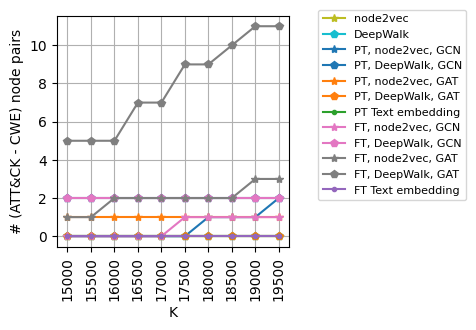

In [23]:
plot_hit_top_pairs()

save file name:  /home/afarhan/post-doc/AWEB_GCL/model_outputs/ics_attack/plots/sample_10/triplet/avg_weak_text_hit@k_gnn_dual3_sample_10.png


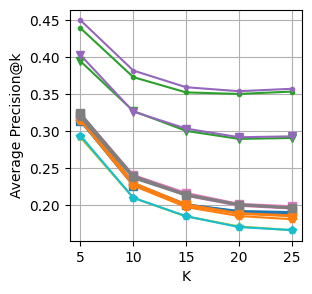

In [389]:
weak_text_hit_differ = plot_hit_k_graph_gnn(text_hop_embeddings["bert"][0], "weak_text", True,0)

save file name:  /home/afarhan/post-doc/AWEB_GCL/model_outputs/ics_attack/plots/sample_10/triplet/avg_text_hit@k_gnn_dual3_sample_10.png


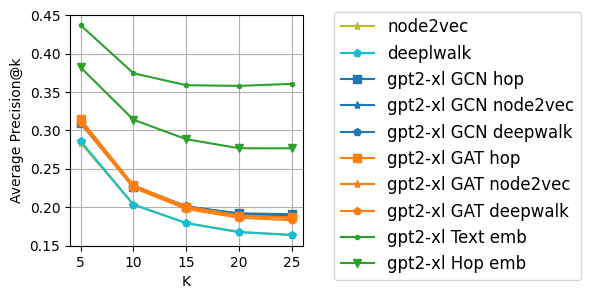

In [405]:
x=plot_hit_k_graph_gnn(text_hop_embeddings["bert"][0], "text", True, 0)

In [398]:
weakness_hop_sim_matrix = np.load(data_dir+'weakness_hop_sim_matrix.npy')
attack_hop_sim_matrix = np.load(data_dir+'attack_hop_sim_matrix.npy')

save file name:  /home/afarhan/post-doc/AWEB_GCL/model_outputs/ics_attack/plots/sample_10/triplet/avg_attack_graph_hit@k_gnn_dual3_sample_10.png


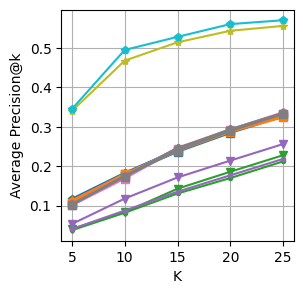

In [402]:
attack_graph_hit_differ = plot_hit_k_graph_gnn(attack_hop_sim_matrix, "attack_graph", True, 0)

save file name:  /home/afarhan/post-doc/AWEB_GCL/model_outputs/ics_attack/plots/sample_10/triplet/avg_weak_graph_hit@k_gnn_dual3_sample_10.png


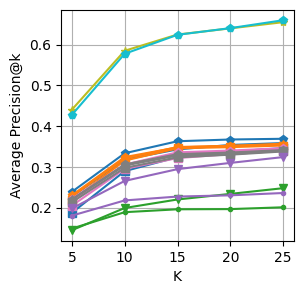

In [403]:
weak_graph_hit_differ = plot_hit_k_graph_gnn(weakness_hop_sim_matrix, "weak_graph", True, 0)

In [335]:
hit_differ={"attack_text":attack_text_hit_differ,
           "weak_text":weak_text_hit_differ,
           "attack_graph":attack_graph_hit_differ,
           "weak_graph":weak_graph_hit_differ}

In [337]:
with open(plot_dir+"hit_difference_{}.json".format(dual),'w') as f:
    json.dump(hit_differ,f)

In [160]:
# plot_hit_k_graph_gnn(text_hop_embeddings["bert"][0], "attack_text", True,1)

In [140]:
# plot_hit_k_graph_gnn(text_hop_embeddings["bert"][0], "weak_text", True,1)

In [120]:
# plot_hit_k_graph_gnn(text_hop_embeddings["bert"][0], "text", True, 1)

In [121]:
# plot_hit_k_graph_gnn(attack_hop_sim_matrix, "attack_graph", True, 1)

In [122]:
# plot_hit_k_graph_gnn(weakness_hop_sim_matrix, "weak_graph", True, 1)